In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

from sklearn.preprocessing import StandardScaler
from keras import metrics

plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

Using TensorFlow backend.


In [2]:
test_final = pd.read_csv('../wrangled_data/testing_post_wrangle_small.csv')
test_final = test_final.loc[:,['ID', 'shop_id', 'item_id']]

train = pd.read_csv('../csv_folder/sales_train.csv')
train = train.pivot_table(index = ['shop_id','item_id'],
                     values = ['item_cnt_day'],
                     columns = ['date_block_num'],
                     fill_value = 0,
                     aggfunc='sum')

train = train.stack().rename(columns={'item_cnt_day':'item_cnt_month'}).unstack().reset_index()
train = pd.merge(test_final, train, left_on = ['item_id','shop_id'], right_on = ['item_id','shop_id'], how='left')
train = train.drop(columns=['ID', 'shop_id', 'item_id']).fillna(0)
train = pd.DataFrame(train.to_numpy())
train

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [4]:
X_train = train_scaled[:,:-1]
X_predict = train_scaled[:,1:]
y_train = train_scaled[:,-1]

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 33) (214200,) (214200, 33)


In [5]:
X_train = X_train.reshape((214200, -1, 1))
X_predict = X_predict.reshape((214200, -1, 1))
y_train = y_train.reshape((214200, -1))

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [6]:
def build_model_cnn_lstm(n_timesteps, n_features, gru_nodes, filters=2, n_series=1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.RepeatVector(n_series))
    model.add(tf.keras.layers.LSTM(gru_nodes, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_series))
    model.compile(loss='mse', optimizer='adam', metrics= ['mean_squared_error'])
    return model

In [7]:
model = build_model_cnn_lstm(33, 1, 128, 2, 1)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 31, 2)             8         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 2)             0         
_________________________________________________________________
flatten (Flatten)            (None, 30)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 30)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            81408     
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [9]:
history = model.fit(X_train, y_train, batch_size = 4096, epochs = 50)

[2021-08-24 06:40:05.291 ip-172-16-88-252:14010 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-24 06:40:05.316 ip-172-16-88-252:14010 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train on 214200 samples
Epoch 1/50
214200/214200 [==============================] - 5s 23us/sample - loss: 0.8138 - mean_squared_error: 0.8138
Epoch 2/50
214200/214200 [==============================] - 3s 15us/sample - loss: 0.7293 - mean_squared_error: 0.7293
Epoch 3/50
214200/214200 [==============================] - 3s 13us/sample - loss: 0.6987 - mean_squared_error: 0.6987
Epoch 4/50
214200/214200 [==============================] - 3s 14us/sample - loss: 0.6413 - mean_squared_error: 0.6413
Epoch 5/50
214200/214200 [==============================] - 3s 14us/sample - loss: 0.6081 - mean_squared_error: 0.6081
Epoch 6/50
214200/214200 [==============================] - 3s 14us/sample - loss: 0.5545 - mean_squared_e

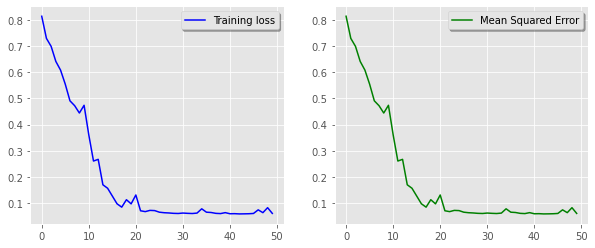

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mean_squared_error'], color='g', label='Mean Squared Error')
ax[1].legend(loc='best', shadow=True)

In [11]:
# creating submission file 
submission_pfs = model.predict(X_predict)

In [12]:
submit_scaled = np.hstack((X_predict.reshape(214200, -1), submission_pfs.reshape(214200, -1)))

In [13]:
submit = scaler.inverse_transform(submit_scaled)
submit.shape

(214200, 34)

In [14]:
pd.DataFrame(submit).loc[:,33]

0         0.420566
1         0.153562
2         0.529676
3         0.257860
4         0.153562
            ...   
214195    0.165301
214196    0.153562
214197    0.075972
214198    0.153562
214199    0.145989
Name: 33, Length: 214200, dtype: float64

In [15]:
submit[:,33]

array([0.42056647, 0.1535625 , 0.52967633, ..., 0.07597229, 0.1535625 ,
       0.14598919])

In [16]:
# we will keep every value between 0 and 20
submit = submit.clip(0,20)

In [17]:
# creating dataframe with required columns 
submit = pd.DataFrame({'ID':test_final['ID'],'item_cnt_month':submit[:,33]})
# creating csv file from dataframe
submit.to_csv('../submission_files/cnn_lstm_stdscaler_epoch50.csv',index = False)

In [18]:
submit

,ID,item_cnt_month
0,0,0.420566
1,1,0.153562
2,2,0.529676
3,3,0.257860
4,4,0.153562
...,...,...
214195,214195,0.165301
214196,214196,0.153562
214197,214197,0.075972
214198,214198,0.153562
